### Using K-means clustering for finding user groups

In [2]:
import pandas as pd
import re
import numpy as np
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.decomposition import PCA
import matplotlib
%matplotlib inline
import seaborn as sns

#### Preparing the initial dataframe

In [3]:
cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('latest/ratings.dat', sep='::',
                    index_col=False, names=cols,
                          encoding="UTF-8", engine='python')

In [4]:
cols = ['movie_id', 'movie_title', 'movie_genre']
movies = pd.read_csv('latest/movies.dat', sep='::',
                    index_col=False, names=cols,
                          encoding="UTF-8", engine='python')
# making a new column for the year of the movie
movies['movie_year'] = movies['movie_title'].apply(lambda x: re.findall('\((.*?)\)',x)[0])
# making new columns for the genres of the movie
movies = movies.join(movies['movie_genre'].str.split('|', 3, expand=True).rename(
    columns={0:'genre1', 1:'genre2', 2:'genre3',3:'genre4'}))


In [5]:
joined = ratings.merge(movies, on='movie_id', how = 'left')

In [6]:
joined['date'] = pd.to_datetime(joined['timestamp'], unit='s')

In [44]:
joined.head(2)

,user_id,movie_id,rating,timestamp,movie_title,movie_genre,movie_year,genre1,genre2,genre3,genre4,date
0,1,68646,10,1381620027,The Godfather (1972),Crime|Drama,1972,Crime,Drama,None,None,2013-10-12 23:20:27
1,1,113277,10,1379466669,Heat (1995),Action|Crime|Drama,1995,Action,Crime,Drama,None,2013-09-18 01:11:09


### Possible features

#### how many movies did the user rate? What is the average and the standard deviation of the ratings?

In [8]:
ratingNumber = joined.groupby('user_id').agg({'rating':{'RatingCount':'count','RatingMean':'mean' ,'RatingStd':'std'}})
ratingNumber.columns = ratingNumber.columns.droplevel(0)
ratingNumber.reset_index(inplace=True)
ratingNumber.fillna(0,inplace=True)

In [12]:
ratingNumber.head(1)

,user_id,RatingStd,RatingMean,RatingCount
0,1,0.0,10.0,2


#### what is the share of voice of genres the user rated?

In [13]:
genre1 = joined[['user_id','genre1']].rename(columns={'genre1':'genre'})
genre2 = joined[['user_id','genre2']].rename(columns={'genre2':'genre'})
genre3 = joined[['user_id','genre3']].rename(columns={'genre3':'genre'})
genre4 = joined[['user_id','genre4']].rename(columns={'genre4':'genre'})

In [14]:
frames = [genre1,genre2,genre3,genre4]
genres = pd.concat(frames)

In [15]:
genres = genres.groupby(['user_id','genre']).agg({'genre':{'count':'count'}})
genres.columns = genres.columns.droplevel(0)
genres.reset_index(inplace=True)

In [16]:
genrePivot = genres.pivot(index='user_id',columns='genre',values='count')
genreNames = genrePivot.columns
genrePivot['sum'] = genrePivot.sum(axis=1)
for name in genreNames:
    genrePivot[name+'_sov'] = genrePivot[name]/genrePivot['sum']
    genrePivot.drop(name, axis=1, inplace=True)
genrePivot.drop('sum', axis=1, inplace=True)
genrePivot.fillna(0, inplace=True)
genrePivot.reset_index(inplace=True)

In [45]:
genrePivot.head(2)

genre,user_id,Action_sov,Adult_sov,Adventure_sov,Animation_sov,Biography_sov,Comedy_sov,Crime_sov,Documentary_sov,Drama_sov,...,News_sov,Reality-TV_sov,Romance_sov,Sci-Fi_sov,Short_sov,Sport_sov,Talk-Show_sov,Thriller_sov,War_sov,Western_sov
0,1,0.200000,0.0,0.000000,0.000000,0.000000,0.000000,0.400000,0.0,0.400000,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
1,2,0.118644,0.0,0.118644,0.016949,0.135593,0.084746,0.016949,0.0,0.254237,...,0.0,0.0,0.050847,0.050847,0.0,0.0,0.0,0.067797,0.0,0.0


#### On average how far in time is the ratings of the user from the first rating of the given movie?

In [23]:
firstRatings = joined.groupby('movie_id').agg({'timestamp':'min'}).reset_index().rename(columns={'timestamp':'firstTimestamp'})
joinedWithFirstRating = joined.merge(firstRatings, on='movie_id', how='left')

### Calculating the time difference between the first rating of the movie and the time of the rating in days
joinedWithFirstRating['timediff'] = (joinedWithFirstRating['timestamp'] - joinedWithFirstRating['firstTimestamp'])/86400
ratingTimes = joinedWithFirstRating.groupby('user_id').agg({'timediff':'mean'}).reset_index()

#### How old are the movies the user rates?

In [24]:
joined['movie_year'] = joined['movie_year'].astype('int')
movieYears = joined.groupby('user_id').agg({'movie_year':'mean'}).reset_index().rename(columns={'movie_year':'AvgMovieYear'})

In [25]:
movieYears.head()

,user_id,AvgMovieYear
0,1,1983.5
1,2,2013.0
2,3,2014.0
3,4,2013.0
4,5,1979.5


#### How popular the movies the user rates? How different the rating of the user from the average rating of the movies?

In [26]:
moviePopularity = joined.groupby('movie_id').agg({'rating':{'moviePopularity':'count','movieAvgRating':'mean'}})
moviePopularity.columns = moviePopularity.columns.droplevel(0)
moviePopularity.reset_index(inplace=True)
moviePopularity = joined.merge(moviePopularity, on='movie_id', how='left')
# Calculating the difference of the current rating from the average of all ratings of the given movie
moviePopularity['ratingdiff'] = abs(moviePopularity['movieAvgRating'] - moviePopularity['rating'])
moviePopularity = moviePopularity.groupby('user_id').agg({'moviePopularity':'mean', 'ratingdiff':'mean'}).reset_index()

### Combining all the possible features and preparing the dataframe for clustering

In [27]:
dfs = [ratingNumber, ratingTimes, movieYears, moviePopularity]
df_joined = reduce(lambda left,right: pd.merge(left,right,on='user_id'), dfs)

### Take only users who rated at least 10 movies
df_filtered = df_joined[df_joined['RatingCount']>9]
df_filtered.drop('user_id', axis=1, inplace=True)


C:\Users\se\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [28]:
# Only around the fifht of users rated at least 10 movies
len(df_joined), len(df_filtered)

(47670, 10051)

In [29]:
# scaling the data
data = scale(df_filtered)

In [94]:
# Finding the k and comparing parameters for the algorithm using the shilhouette measure
highest_shil_coeff = 0
for i in range(2,8):
    pca = PCA(n_components=i).fit(data)
    estimator = KMeans(init=pca.components_, n_clusters=i, n_init=1)
    estimator.fit(data)
    shil = metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean',
                                      sample_size=len(df_filtered))
    if shil > highest_shil_coeff:
        best_method = ('pca', i)
        highest_shil_coeff = shil
    estimator = KMeans(init="k-means++", n_clusters=i, n_init=1)
    estimator.fit(data)
    shil = metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean',
                                      sample_size=len(df_filtered))
    if shil > highest_shil_coeff:
        best_method = ('k-means++', i)
        highest_shil_coeff = shil
print best_method, highest_shil_coeff   

('pca', 6) 0.221528422351


In [30]:
#Clustering with the winner settings
pca = PCA(n_components=6).fit(data)
estimator = KMeans(init=pca.components_, n_clusters=6, n_init=1)
estimator.fit(data)

KMeans(algorithm='auto', copy_x=True,
    init=array([[ 0.05964,  0.06549,  0.28445,  0.4919 , -0.55341, -0.6004 ,
         0.05037],
       [ 0.70398, -0.4068 ,  0.07738, -0.05968,  0.12087, -0.05121,  0.5587 ],
       [-0.08101, -0.63872,  0.55621, -0.16516,  0.09211, -0.07507,
        -0.48446],
       [-0.1149 ,  0.44213,  0.75926,  0.0...   0.14305],
       [ 0.31193,  0.01964,  0.13256,  0.1527 , -0.556  ,  0.71719,
        -0.19476]]),
    max_iter=300, n_clusters=6, n_init=1, n_jobs=1,
    precompute_distances='auto', random_state=None, tol=0.0001, verbose=0)

In [ ]:
df_filtered['cluster'] = estimator.labels_

### Let's take a closer look the clusters in order of their sizes

In [32]:
df_filtered['cluster'].value_counts()

5    4202
1    1981
0    1412
4    1184
3     825
2     447
Name: cluster, dtype: int64

### Cluster 5 - Typical movie fans
#### Biggest cluster, rates mainly new movies, and makes the rating soon. Their ratings are similar to the common ratings

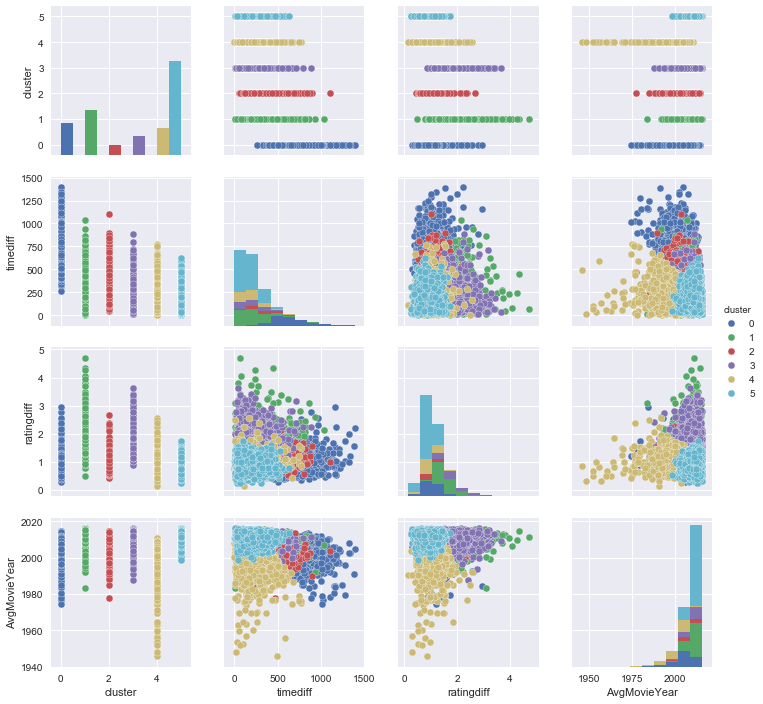

In [38]:
forplotting = df_filtered[['cluster','timediff','ratingdiff', 'AvgMovieYear']]
sns.pairplot(forplotting, hue="cluster")

### Cluster 1 - Critical audience
#### Still big cluster, their ratings can be highly diverse, different from the common liking and more negative

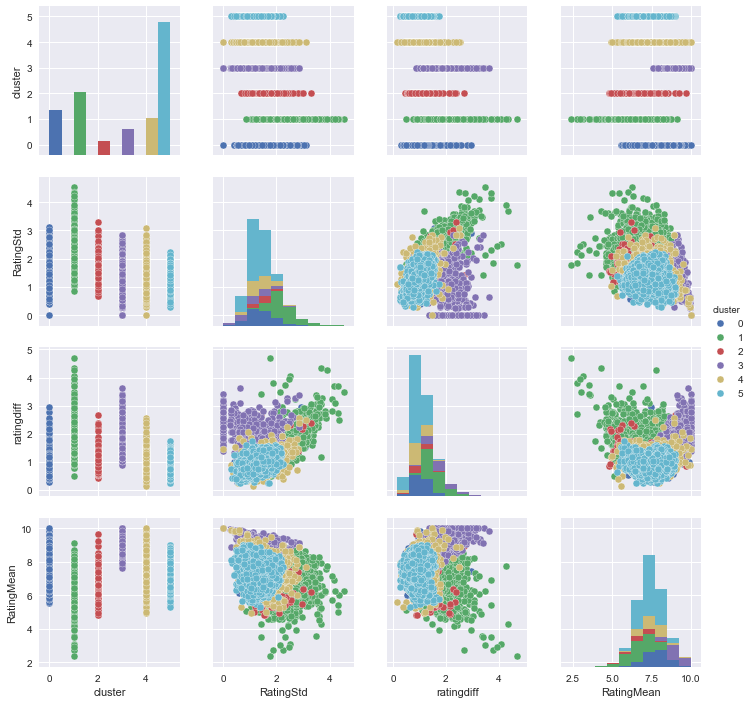

In [40]:
forplotting = df_filtered[['cluster','RatingStd','ratingdiff', 'RatingMean']]
sns.pairplot(forplotting, hue="cluster")

### Cluster 0 - All time classic likers
#### Rates a bit older movies, gives high ratings but doesn't rate as soon as possible

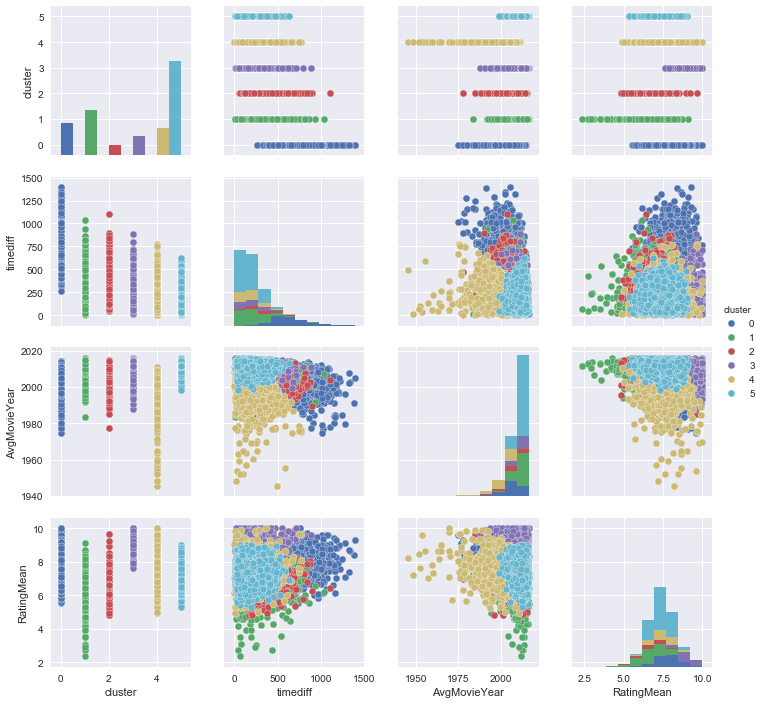

In [41]:
forplotting = df_filtered[['cluster','timediff','AvgMovieYear', 'RatingMean']]
sns.pairplot(forplotting, hue="cluster")

### Cluster 4 - Cinema historians
#### Rates even very old movies which are not rated that often

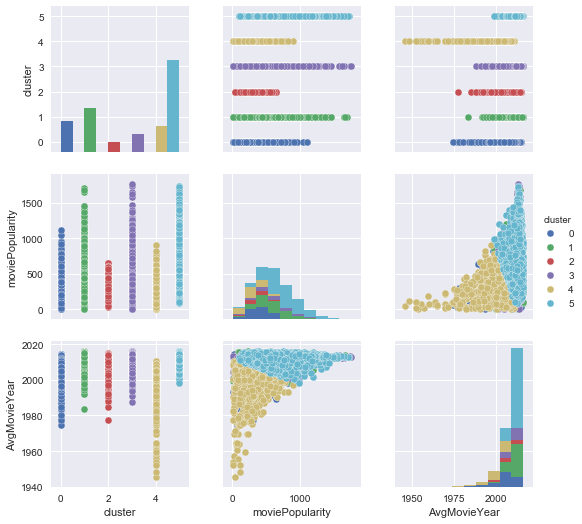

In [42]:
forplotting = df_filtered[['cluster','moviePopularity','AvgMovieYear']]
sns.pairplot(forplotting, hue="cluster")

### Cluster 3 and 2 - Positive raters and Intense raters
#### Smaller clusters, with users rating only movies they really liked and with users rating very high amount of movies

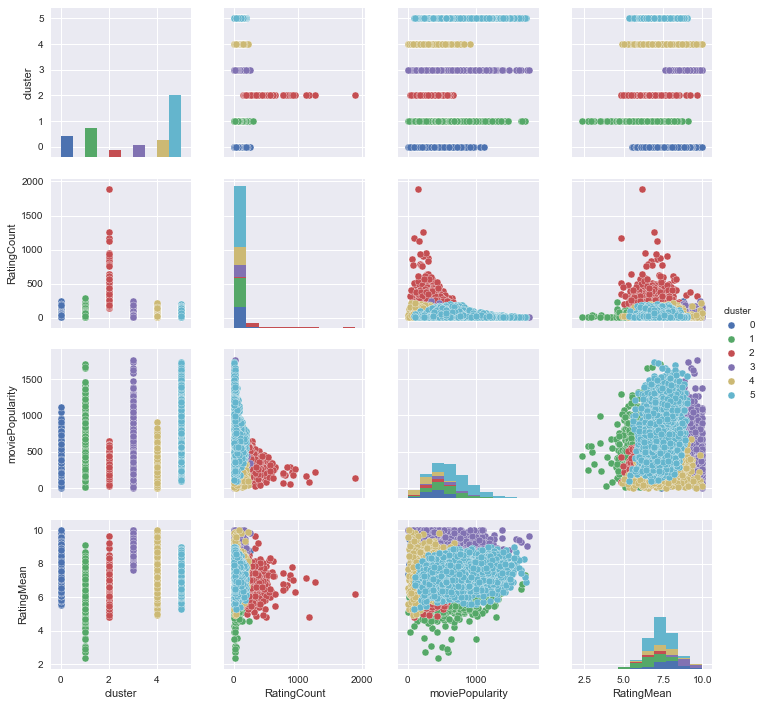

In [43]:
forplotting = df_filtered[['cluster','RatingCount', 'moviePopularity','RatingMean']]
sns.pairplot(forplotting, hue="cluster")